In [62]:
from importlib import reload
import re
import random
random.seed(1337)
import os
import pickle
import itertools
import functools
import operator

import numpy as np
np.random.seed(1337)
import pandas as pd
import scipy.stats as stats
import ahocorasick

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib_config
import seaborn as sns
from plotnine import *

import keras
from keras import backend as K
from keras import losses
from keras.models import load_model
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import model
import utils

In [63]:
reload(matplotlib_config)
matplotlib_config.paper_config()

In [2]:
with open("../Data/data_dict.pkl", 'rb') as handle:
    data_dict = pickle.load(handle)
    
seq_df = pd.read_csv("../Data/gencodev19_5utr_seq.csv")

data_df = data_dict["mpra"]
snv_df = data_dict["snv"]
ptr_df = data_dict["ptr"]
doudna_df = data_dict["doudna"]
varlen_df = data_dict["varlen_mpra"]

In [3]:
mpra_df = data_df[data_df["library"] == "egfp_unmod_1"]

### Human UTR distribution

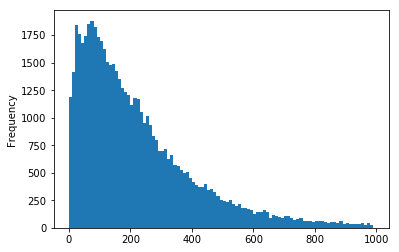

In [12]:
seq_df["utr"].str.len().plot.hist(bins=np.arange(0,1000,10))

In [76]:
(np.sum((seq_df["utr"].str.len() <= 200) & (seq_df["utr"].str.len() > 0))/len(seq_df["utr"]))*100

55.489319423745656

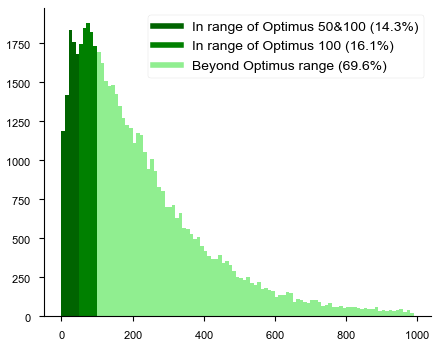

In [64]:
colors = ["darkgreen", "green", "lightgreen"]
font_size=10
fig_dims = (5.0, 4.0)

fig, ax = plt.subplots()
N, bins, patches = ax.hist(seq_df["utr"].str.len(), bins=np.arange(0,1000,10), color=colors[2])

for i in range(0,5):
    patches[i].set_facecolor(colors[0])
for i in range(5,10):    
    patches[i].set_facecolor(colors[1])

optimus50_pct = (np.sum(seq_df["utr"].str.len() <= 50)/len(seq_df["utr"]))*100
optimus100_pct = (np.sum((seq_df["utr"].str.len() <= 100) & (seq_df["utr"].str.len() > 50))/len(seq_df["utr"]))*100
beyond_pct = (np.sum(seq_df["utr"].str.len() > 100)/len(seq_df["utr"]))*100
    
custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4)]
ax.legend(custom_lines, ["In range of Optimus 50&100 (" + str(round(optimus50_pct,1)) + "%)",
                         "In range of Optimus 100 (" + str(round(optimus100_pct,1)) + "%)",
                         "Beyond Optimus range (" + str(round(beyond_pct,1)) + "%)"],
         fontsize=font_size)
sns.despine(fig)
fig.set_size_inches(fig_dims)
fig.savefig("../Graphics/utrlen_hist.svg")

### Variable length MPRA

In [5]:
hits = varlen_df["utr"].str.rfind("ATG")
hit_df = varlen_df.copy()
hit_df["hits"] = hits
hit_df = hit_df[hit_df["hits"] > -1]
hit_df["dist"] = hit_df["len"] - hit_df["hits"]
hit_df["hit_bins"] = pd.cut(hit_df["len"] - hit_df["hits"], np.arange(0, 100, 1))
hit_df["frame"] = (hit_df["len"] - hit_df["hits"]) %3

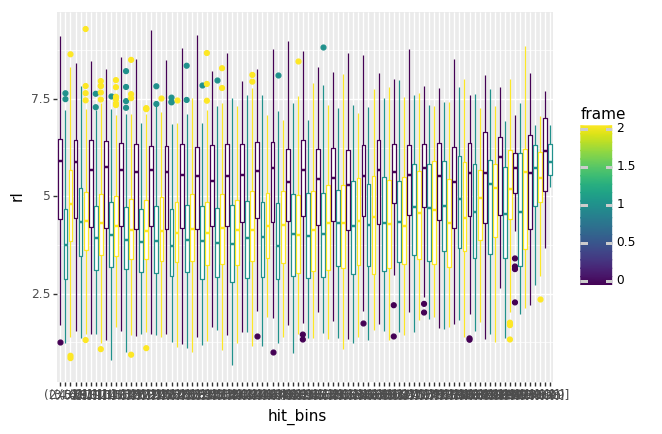

<ggplot: (-9223363284089607024)>

In [6]:
(ggplot(aes(x="hit_bins", y="rl"), data=hit_df) + 
 geom_boxplot(aes(color="frame")))

In [7]:
hit_df_1aug = hit_df[hit_df.utr.str.count("ATG") == 1]

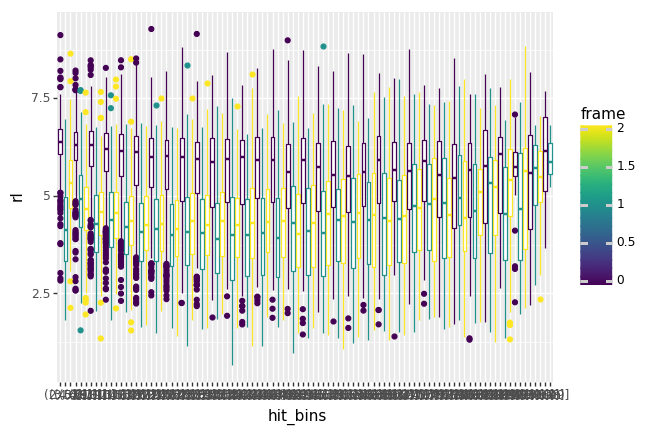

<ggplot: (8752764380813)>

In [8]:
(ggplot(aes(x="hit_bins", y="rl"), data=hit_df_1aug) + 
 geom_boxplot(aes(color="frame")))

In [ ]:
hits = varlen_df["utr"].str.find("ATG")
hit_df_left = varlen_df.copy()
hit_df_left["hits"] = hits
hit_df_left = hit_df_left[hit_df_left["hits"] > -1]
hit_df_left["dist"] = hit_df_left["len"] - hit_df_left["hits"]
hit_df_left["hit_bins"] = pd.cut(hit_df_left["len"] - hit_df_left["hits"], np.arange(0, 100, 1))
hit_df_left["frame"] = (hit_df_left["len"] - hit_df_left["hits"]) %3

### Summary stats

### the uAUG effect

Ttest_indResult(statistic=457.3758292877374, pvalue=0.0)
Ttest_indResult(statistic=59.64218402089369, pvalue=0.0)


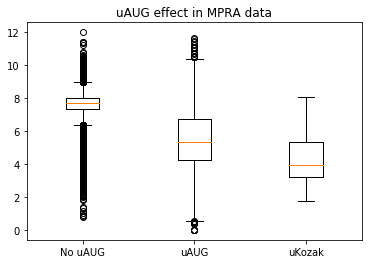

In [128]:
mpra_noaug = mpra_df[~mpra_df["utr"].str.contains("ATG")]["rl"]
mpra_aug = mpra_df[mpra_df["utr"].str.contains("ATG")]["rl"]
mpra_kozak = mpra_df[mpra_df["utr"].str.contains("GCCATGGC")]["rl"]
fig1, ax1 = plt.subplots()
ax1.set_title('uAUG effect in MPRA data')
ax1.boxplot([mpra_noaug, mpra_aug, mpra_kozak], labels=["No uAUG", "uAUG", "uKozak"])
print(stats.ttest_ind(mpra_noaug, mpra_aug))
print(stats.ttest_ind(mpra_noaug, mpra_kozak))

Ttest_indResult(statistic=16.22421441351702, pvalue=6.1335217008563545e-59)
Ttest_indResult(statistic=5.8584661166513925, pvalue=4.7787651959936414e-09)


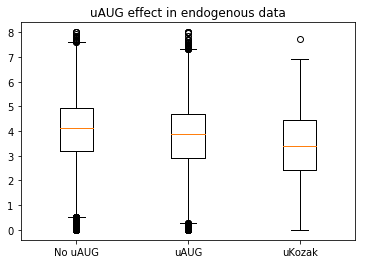

In [126]:
doudna_noaug = doudna_df[~doudna_df["utr"].str.contains("ATG")]["rl"]
doudna_aug = doudna_df[doudna_df["utr"].str.contains("ATG")]["rl"]
doudna_kozak = doudna_df[doudna_df["utr"].str.contains("GCCATGGC")]["rl"]
fig1, ax1 = plt.subplots()
ax1.set_title('uAUG effect in endogenous data')
ax1.boxplot([doudna_noaug, doudna_aug, doudna_kozak], labels=["No uAUG", "uAUG", "uKozak"])
print(stats.ttest_ind(doudna_noaug, doudna_aug))
print(stats.ttest_ind(doudna_noaug, doudna_kozak))

### Out of frame uAUG effect

In [116]:
def motif_checker(motif):
    def checkfor_OOF_Motif(seq):
        motive_indices = [m.start() for m in re.finditer(motif, seq)]
        for idx in motive_indices:
            if (len(seq) - idx - 1) % 3 != 2:
                return True
        return False
    return checkfor_OOF_Motif

Ttest_indResult(statistic=608.5090540035186, pvalue=0.0)


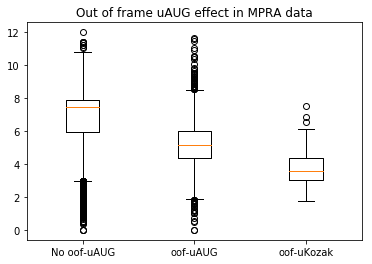

In [124]:
oofaug = motif_checker("ATG")
oofkozak = motif_checker("GCCATGGC")
ooftest = mpra_df["utr"].apply(oofaug)
oofkozak = mpra_df["utr"].apply(oofkozak)
mpra_nooof = mpra_df[~ooftest]["rl"]
mpra_oof = mpra_df[ooftest]["rl"]
mpra_oofkozak = mpra_df[oofkozak]["rl"]
fig1, ax1 = plt.subplots()
ax1.set_title('Out of frame uAUG effect in MPRA data')
ax1.boxplot([mpra_noorf, mpra_orf, mpra_oofkozak], labels=["No oof-uAUG", "oof-uAUG", "oof-uKozak"])
print(stats.ttest_ind(mpra_nooof, mpra_oof))

Ttest_indResult(statistic=17.361173981636306, pvalue=3.5139246646200514e-67)


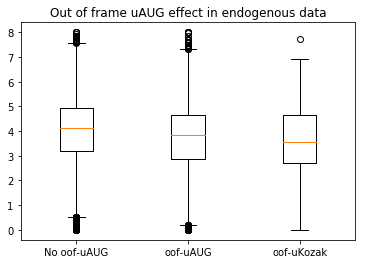

In [125]:
oofaug = motif_checker("ATG")
oofkozak = motif_checker("GCCATGGC")
ooftest = doudna_df["utr"].apply(oofaug)
oofkozak = doudna_df["utr"].apply(oofkozak)
doudna_nooof = doudna_df[~ooftest]["rl"]
doudna_oof = doudna_df[ooftest]["rl"]
doudna_oofkozak = doudna_df[oofkozak]["rl"]
fig1, ax1 = plt.subplots()
ax1.set_title('Out of frame uAUG effect in endogenous data')
ax1.boxplot([doudna_nooof, doudna_oof, doudna_oofkozak], labels=["No oof-uAUG", "oof-uAUG", "oof-uKozak"])
print(stats.ttest_ind(doudna_nooof, doudna_oof))

### The uORF effect

In [19]:
def check_for_uORF(seq):
    start_indices = [m.start() for m in re.finditer('ATG', seq)]
    stop_indices = [m.start() for m in re.finditer('TGA', seq)] + \
                   [m.start() for m in re.finditer('TAA', seq)] + \
                   [m.start() for m in re.finditer('TAG', seq)]
    for i in range(3):
        frame_start = [idx for idx in start_indices if idx % 3 == i]
        frame_stop = [idx for idx in stop_indices if idx % 3 == i]
        for start_idx in frame_start:
            for stop_idx in frame_stop:
                if start_idx < stop_idx:
                    return True
    return False

Ttest_indResult(statistic=221.72442950808696, pvalue=0.0)


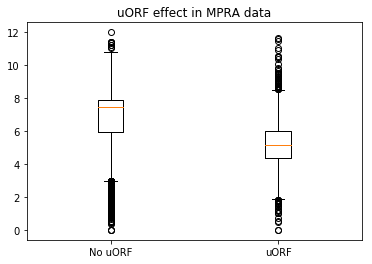

In [41]:
orftest = mpra_df["utr"].apply(check_for_uORF)
mpra_noorf = mpra_df[~orftest]["rl"]
mpra_orf = mpra_df[orftest]["rl"]
fig1, ax1 = plt.subplots()
ax1.set_title('uORF effect in MPRA data')
ax1.boxplot([mpra_noorf, mpra_orf], labels=["No uORF", "uORF"])
print(stats.ttest_ind(mpra_noorf, mpra_orf))

Ttest_indResult(statistic=16.774366222611132, pvalue=7.37029876445238e-63)


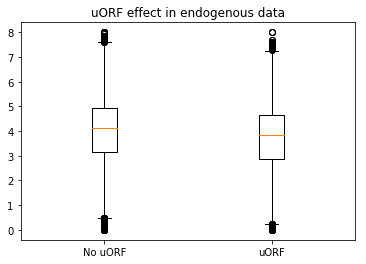

In [42]:
orftest = doudna_df["utr"].apply(check_for_uORF)
doudna_noorf = doudna_df[~orftest]["rl"]
doudna_orf = doudna_df[orftest]["rl"]
fig1, ax1 = plt.subplots()
ax1.set_title('uORF effect in endogenous data')
ax1.boxplot([doudna_noorf, doudna_orf], labels=["No uORF", "uORF"])
print(stats.ttest_ind(doudna_noorf, doudna_orf))

### PolyU

In [46]:
polyU = "T"*5

Ttest_indResult(statistic=-13.322924408886246, pvalue=1.75215633203937e-40)


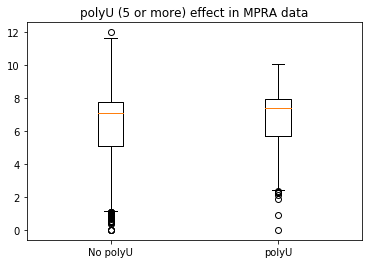

In [47]:
mpra_nopolyU = mpra_df[~mpra_df["utr"].str.contains(polyU)]["rl"]
mpra_polyU = mpra_df[mpra_df["utr"].str.contains(polyU)]["rl"]
fig1, ax1 = plt.subplots()
ax1.set_title('polyU (5 or more) effect in MPRA data')
ax1.boxplot([mpra_nopolyU, mpra_polyU], labels=["No polyU", "polyU"])
print(stats.ttest_ind(mpra_nopolyU, mpra_polyU))

Ttest_indResult(statistic=6.5524224382223855, pvalue=5.7545747743871956e-11)


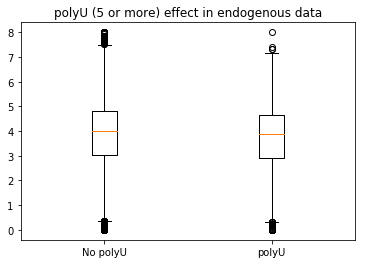

In [48]:
doudna_nopolyU = doudna_df[~doudna_df["utr"].str.contains(polyU)]["rl"]
doudna_polyU = doudna_df[doudna_df["utr"].str.contains(polyU)]["rl"]
fig1, ax1 = plt.subplots()
ax1.set_title('polyU (5 or more) effect in endogenous data')
ax1.boxplot([doudna_nopolyU, doudna_polyU], labels=["No polyU", "polyU"])
print(stats.ttest_ind(doudna_nopolyU, doudna_polyU))

### GC Content

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Pearson: -0.068, p-val: 0.000, squared: 0.005, Spearman: -0.123, p-val: 0.000


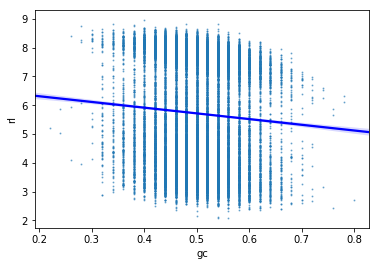

In [70]:
mpra_df["gc"] = (mpra_df["utr"].str.count("G") + mpra_df["utr"].str.count("C"))/mpra_df["utr"].str.len()
utils.print_corrs(mpra_df["gc"], mpra_df["rl"])
x = sns.regplot(x='gc', y="rl", data=mpra_df[mpra_df.set == "test"], line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()

Pearson: 0.043, p-val: 0.000, squared: 0.002, Spearman: 0.046, p-val: 0.000


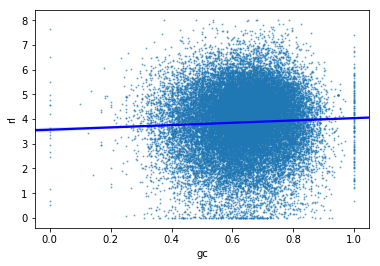

In [71]:
doudna_df["gc"] = (doudna_df["utr"].str.count("G") + doudna_df["utr"].str.count("C"))/doudna_df["utr"].str.len()
utils.print_corrs(doudna_df["gc"], doudna_df["rl"])
x = sns.regplot(x='gc', y="rl", data=doudna_df, line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()

### Energy

Pearson: 0.435, p-val: 0.000, squared: 0.189, Spearman: 0.482, p-val: 0.000


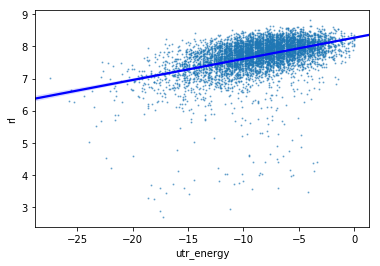

In [83]:
mpra_df_noaug = mpra_df[~mpra_df["utr"].str.contains("ATG")]
utils.print_corrs(mpra_df_noaug[mpra_df_noaug.set == "test"]["utr_energy"], mpra_df_noaug[mpra_df_noaug.set == "test"]["rl"])
x = sns.regplot(x='utr_energy', y="rl", data=mpra_df_noaug[mpra_df_noaug.set == "test"], line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()

In [84]:
utils.print_corrs(mpra_df_noaug["utr_energy"], mpra_df_noaug["rl"])

Pearson: 0.372, p-val: 0.000, squared: 0.139, Spearman: 0.432, p-val: 0.000


Pearson: 0.116, p-val: 0.000, squared: 0.013, Spearman: 0.114, p-val: 0.000


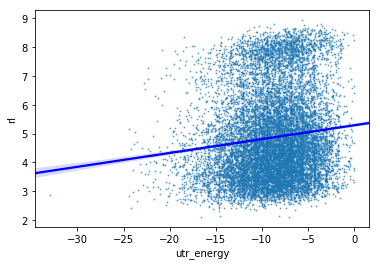

In [94]:
mpra_df_aug = mpra_df[mpra_df["utr"].str.contains("ATG")]
utils.print_corrs(mpra_df_aug[mpra_df_aug.set == "test"]["utr_energy"], mpra_df_aug[mpra_df_aug.set == "test"]["rl"])
x = sns.regplot(x='utr_energy', y="rl", data=mpra_df_aug[mpra_df_aug.set == "test"], line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()

Pearson: -0.059, p-val: 0.000, squared: 0.004, Spearman: -0.068, p-val: 0.000


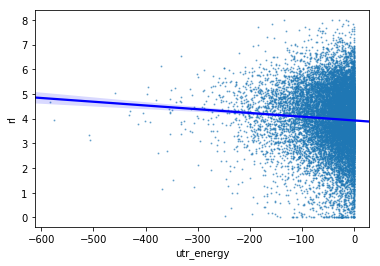

In [86]:
doudna_df_noaug = doudna_df[~doudna_df["utr"].str.contains("ATG")]
utils.print_corrs(doudna_df_noaug["utr_energy"], doudna_df_noaug["rl"])
x = sns.regplot(x='utr_energy', y="rl", data=doudna_df_noaug, line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()

Pearson: -0.039, p-val: 0.000, squared: 0.002, Spearman: -0.037, p-val: 0.000


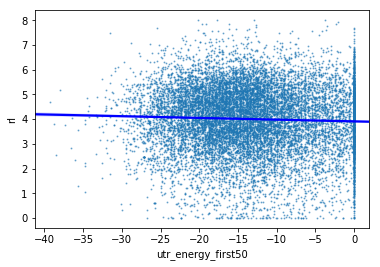

In [88]:
utils.print_corrs(doudna_df_noaug["utr_energy_first50"], doudna_df_noaug["rl"])
x = sns.regplot(x='utr_energy_first50', y="rl", data=doudna_df_noaug, line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()

Pearson: -0.020, p-val: 0.021, squared: 0.000, Spearman: -0.018, p-val: 0.035


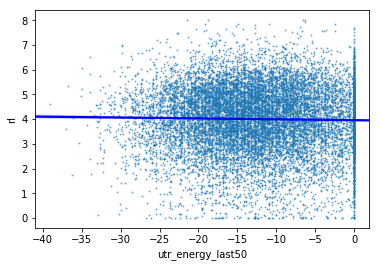

In [87]:
utils.print_corrs(doudna_df_noaug["utr_energy_last50"], doudna_df_noaug["rl"])
x = sns.regplot(x='utr_energy_last50', y="rl", data=doudna_df_noaug, line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()